In [1]:
# ===============================================================================
# FIGURE S3
# ===============================================================================

library(dplyr)
library(tidyr)
library(ggplot2)
library(gridExtra)
library(scales)

# ===============================================================================
# SETUP
# ===============================================================================

data_dir <- "./data"

# Color palettes
vc_colors <- c(
  "Missense_Mutation" = "#E31A1C", "Nonsense_Mutation" = "#FF7F00",
  "Frame_Shift_Del" = "#B15928", "Frame_Shift_Ins" = "#A6CEE3",
  "In_Frame_Del" = "#1F78B4", "Silent" = "#B2DF8A",
  "Intron" = "#99D8C9", "RNA" = "#74C476",
  "3'UTR" = "#41B6C4", "5'UTR" = "#2C7FB8"
)

silent_colors <- c("Silent" = "#B2DF8A", "Non-silent" = "#E31A1C")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# ===============================================================================
# LOAD DATA
# ===============================================================================

cat("Loading data for Figure S3...\n")

# Aggregated analysis data
level1_combined <- read.csv(file.path(data_dir, "Level1_Event_Type_COMBINED.csv"))
level1_permutations <- read.csv(file.path(data_dir, "Level1_Event_Type_permutations.csv"))
level1_cancer <- read.csv(file.path(data_dir, "Level1_Event_Type_cancer_breakdown.csv"))
level1b_combined <- read.csv(file.path(data_dir, "Level1b_Event_Type_Silent_Status_COMBINED.csv"))
level1b_permutations <- read.csv(file.path(data_dir, "Level1b_Event_Type_Silent_Status_permutations.csv"))
level1b_cancer <- read.csv(file.path(data_dir, "Level1b_Event_Type_Silent_Status_cancer_breakdown.csv"))

# Paired t-test data
paired_data <- read.csv(file.path(data_dir, "paired_data_complete_with_keys.csv"))

cat("✅ Data loaded\n\n")

# ===============================================================================
# HELPER FUNCTIONS
# ===============================================================================

# Distribution plot function
create_distribution_plot <- function(event_name, combined_data, permutation_data,
                                    cancer_data, filter_col = "Event_Type",
                                    filter_val = NULL, filter_col2 = NULL,
                                    filter_val2 = NULL, title_text = NULL,
                                    panel_label = "") {

  if (!is.null(filter_col2)) {
    plot_combined <- combined_data %>%
      filter(!!sym(filter_col) == filter_val & !!sym(filter_col2) == filter_val2)
    plot_perm <- permutation_data %>%
      filter(!!sym(filter_col) == filter_val & !!sym(filter_col2) == filter_val2)
    plot_cancer <- cancer_data %>%
      filter(!!sym(filter_col) == filter_val & !!sym(filter_col2) == filter_val2)
  } else {
    plot_combined <- combined_data %>% filter(!!sym(filter_col) == filter_val)
    plot_perm <- permutation_data %>% filter(!!sym(filter_col) == filter_val)
    plot_cancer <- cancer_data %>% filter(!!sym(filter_col) == filter_val)
  }

  observed_mean <- plot_combined$observed_mean[1]
  null_mean <- plot_combined$null_mean[1]
  z_score <- plot_combined$z_score[1]
  p_value <- plot_combined$p_value[1]

  p_main <- ggplot(plot_perm, aes(x = permutation_value)) +
    geom_histogram(bins = 50, fill = "lightblue", color = "black", alpha = 0.7) +
    geom_vline(xintercept = null_mean, color = "blue", linetype = "dashed", linewidth = 1) +
    geom_vline(xintercept = observed_mean, color = "red", linewidth = 1.2) +
    labs(title = paste0(panel_label, " ", if(!is.null(title_text)) title_text else event_name),
         x = "Mean m6A Level", y = "Frequency") +
    annotate("text", x = Inf, y = Inf, hjust = 1.1, vjust = 2,
             label = sprintf("Observed = %.2f\nNull = %.2f\nZ = %.2f\np = %.4f",
                           observed_mean, null_mean, z_score, p_value), size = 4) +
    theme_minimal(base_size = 12) +
    theme(plot.title = element_text(face = "bold", hjust = 0, size = 14))

  plot_cancer <- plot_cancer %>% arrange(desc(mean_m6a))

  p_inset <- ggplot(plot_cancer, aes(x = reorder(Cancer_type, -mean_m6a), y = mean_m6a, fill = Cancer_type)) +
    geom_col() +
    geom_hline(yintercept = null_mean, color = "blue", linetype = "dashed", linewidth = 0.8) +
    geom_hline(yintercept = observed_mean, color = "red", linewidth = 0.8) +
    geom_text(aes(label = sprintf("n=%d", n)), vjust = -0.5, size = 2.5) +
    labs(title = "Cancer Type Breakdown", x = NULL, y = "Mean m6A Level") +
    theme_minimal(base_size = 8) +
    theme(legend.position = "none", plot.title = element_text(face = "bold", hjust = 0.5, size = 9),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 7))

  return(list(main = p_main, inset = p_inset))
}

# Paired t-test plot function
create_paired_plot <- function(data, color_var = "Silent_Status", color_palette = NULL,
                              title = "", panel_label = "") {

  data <- data %>% filter(!is.na(.data[[color_var]]))
  if (nrow(data) == 0) return(NULL)

  n_pairs <- nrow(data)
  mean_diff <- mean(data$difference, na.rm = TRUE)
  t_result <- t.test(data$difference)
  p_value <- t_result$p.value

  p_text <- if (p_value < 0.001) sprintf("p = %.2e", p_value)
            else if (p_value < 0.01) sprintf("p = %.4f", p_value)
            else sprintf("p = %.2f", p_value)

  plot_data_long <- data %>%
    select(mutation_key, mutation_m6a, control_mean, !!sym(color_var)) %>%
    pivot_longer(cols = c(control_mean, mutation_m6a), names_to = "Group", values_to = "m6A_Level") %>%
    mutate(Group = factor(Group, levels = c("control_mean", "mutation_m6a"),
                         labels = c("Wild Type", "Mutant")),
           Group_numeric = as.numeric(Group))

  plot_data_wide <- data %>% select(mutation_key, control_mean, mutation_m6a, !!sym(color_var))

  y_range <- range(plot_data_long$m6A_Level, na.rm = TRUE)
  y_span <- diff(y_range)
  stats_x <- 1.85
  stats_y <- y_range[2] - 0.05 * y_span

  p <- ggplot() +
    geom_segment(data = plot_data_wide,
                aes(x = 1, y = control_mean, xend = 2, yend = mutation_m6a, color = !!sym(color_var)),
                alpha = 0.3, linewidth = 0.5) +
    geom_boxplot(data = plot_data_long, aes(x = Group_numeric, y = m6A_Level, group = Group),
                fill = NA, color = "black", width = 0.4, outlier.shape = NA, linewidth = 0.8) +
    geom_point(data = plot_data_long, aes(x = Group_numeric, y = m6A_Level, color = !!sym(color_var)),
              size = 3, alpha = 0.7) +
    annotate("text", x = stats_x, y = stats_y,
            label = sprintf("n = %d pairs\nTwo-tail %s\nMean diff = %.2f", n_pairs, p_text, mean_diff),
            hjust = 1, vjust = 1, size = 4, lineheight = 0.9) +
    scale_x_continuous(breaks = c(1, 2), labels = c("Wild Type", "Mutant"), limits = c(0.6, 2.4)) +
    labs(title = paste0(panel_label, " ", title), x = NULL, y = "m6A Level") +
    theme_bw(base_size = 14) +
    theme(plot.title = element_text(face = "bold", size = 16, hjust = 0),
          axis.text.x = element_text(size = 14, face = "bold"),
          legend.position = "right", panel.grid.major.x = element_blank())

  if (!is.null(color_palette)) {
    present_values <- unique(plot_data_long[[color_var]])
    palette_filtered <- color_palette[names(color_palette) %in% present_values]
    p <- p + scale_color_manual(values = palette_filtered, name = gsub("_", " ", color_var))
  }

  return(p)
}

Loading data for Figure S3...
✅ Data loaded




################################################################################
# FIGURE S3: SUPPLEMENTARY ANALYSES                                            #
################################################################################

Generating panel (a): Silent Disruption distribution...


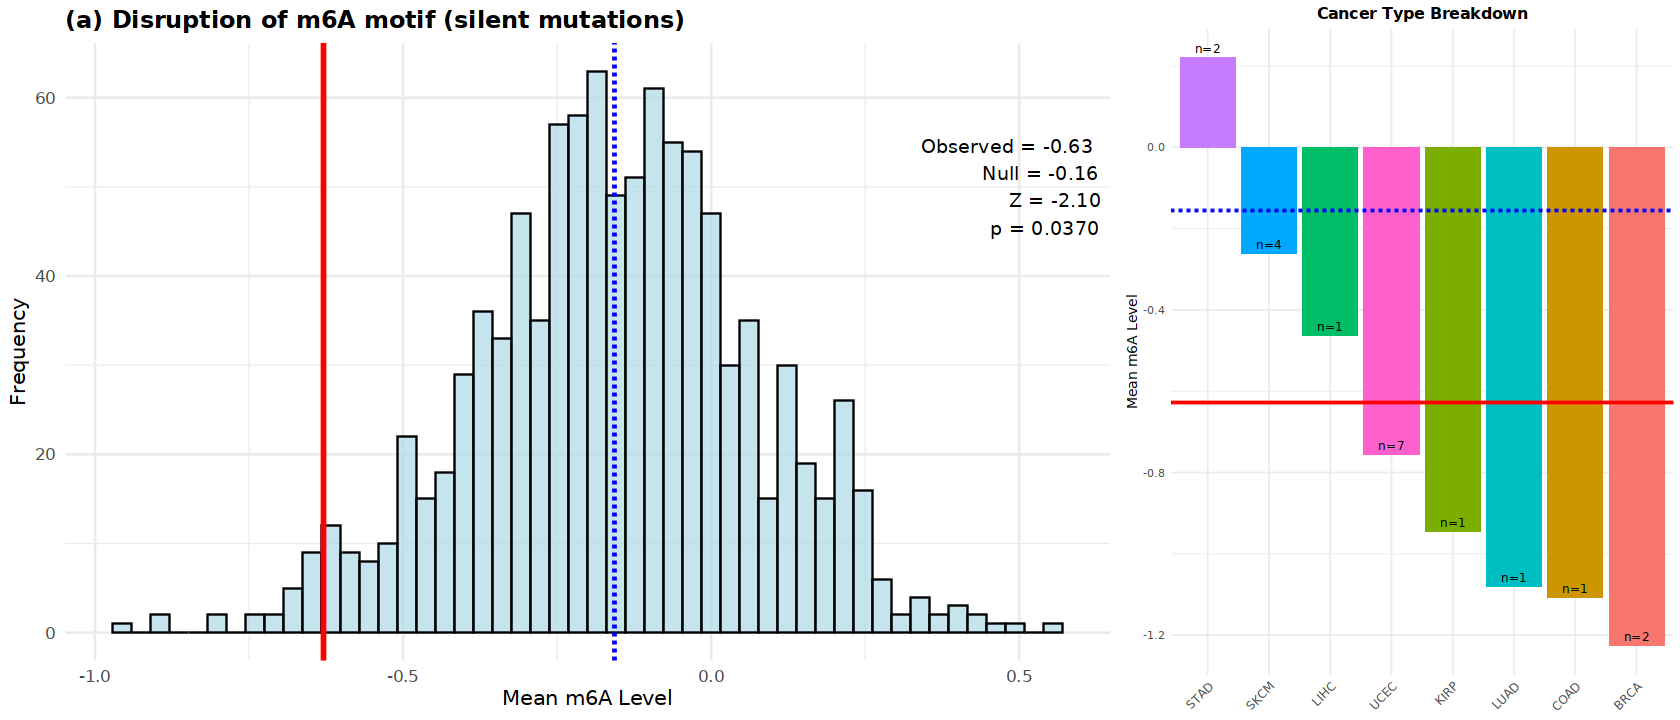

In [3]:
# ===============================================================================
# FIGURE S3 PANELS
# ===============================================================================

cat("\n################################################################################\n")
cat("# FIGURE S3: SUPPLEMENTARY ANALYSES                                            #\n")
cat("################################################################################\n\n")

# Panel a: Silent Disruption distribution
cat("Generating panel (a): Silent Disruption distribution...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3a <- create_distribution_plot("Silent Disruption", level1b_combined, level1b_permutations,
                                   level1b_cancer, filter_val = "Disruption",
                                   filter_col2 = "Silent_Status", filter_val2 = "Silent",
                                   title_text = "Disruption of m6A motif (silent mutations)",
                                   panel_label = "(a)")
grid.arrange(figS3a$main, figS3a$inset, ncol = 2, widths = c(2, 1))

Generating panel (b): Disruption by Silent/Non-silent...


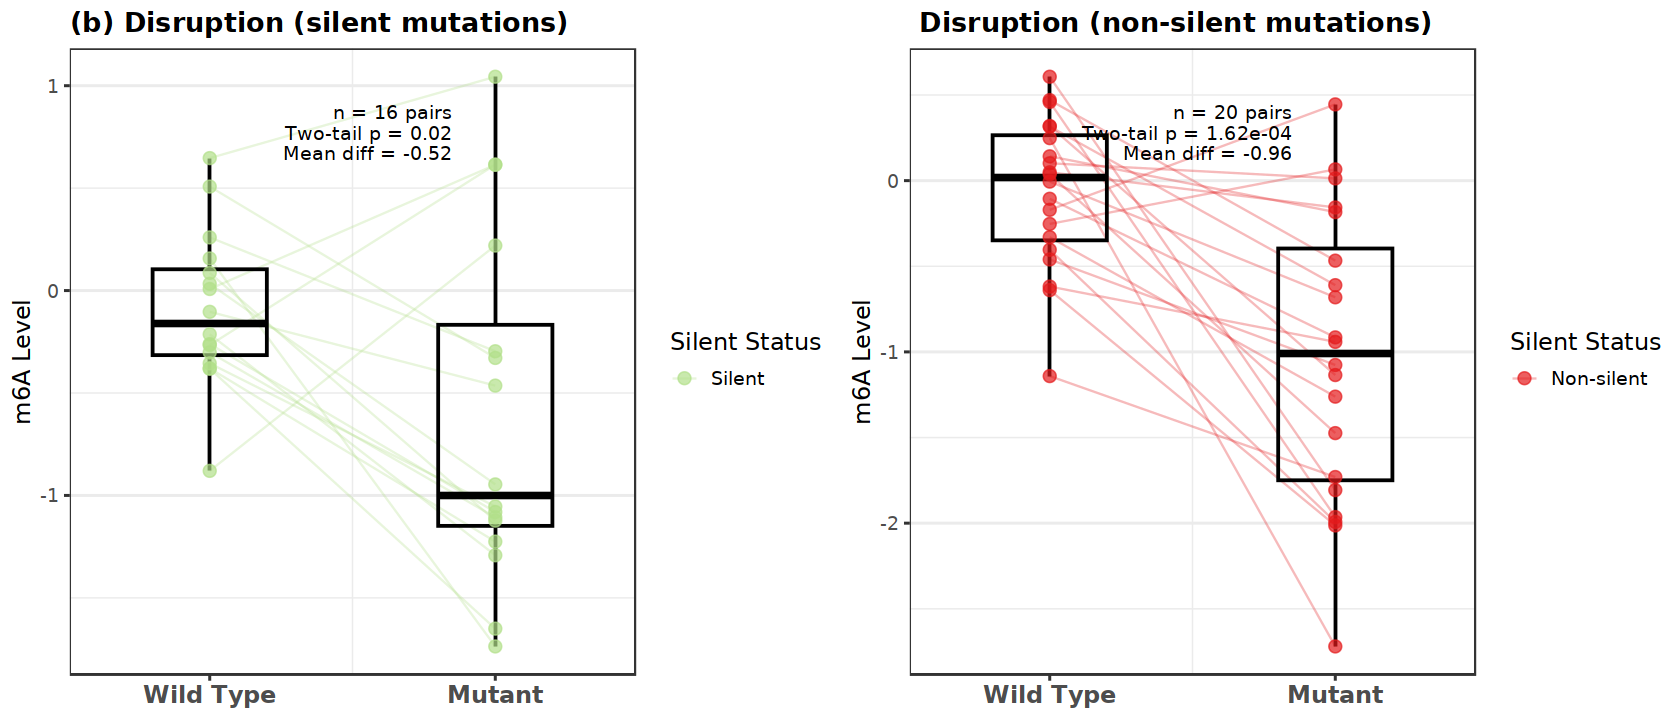

In [4]:
# Panel b: Disruption by Silent/Non-silent
cat("Generating panel (b): Disruption by Silent/Non-silent...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3b_silent <- paired_data %>% filter(Event_Type == "Disruption", Silent_Status == "Silent")
figS3b_nonsilent <- paired_data %>% filter(Event_Type == "Disruption", Silent_Status == "Non-silent")

figS3b_p1 <- create_paired_plot(figS3b_silent, "Silent_Status", silent_colors,
                                "Disruption (silent mutations)", "(b)")
figS3b_p2 <- create_paired_plot(figS3b_nonsilent, "Silent_Status", silent_colors,
                                "Disruption (non-silent mutations)", "")
grid.arrange(figS3b_p1, figS3b_p2, ncol = 2)

Generating panel (c): Disruption of AGACC...


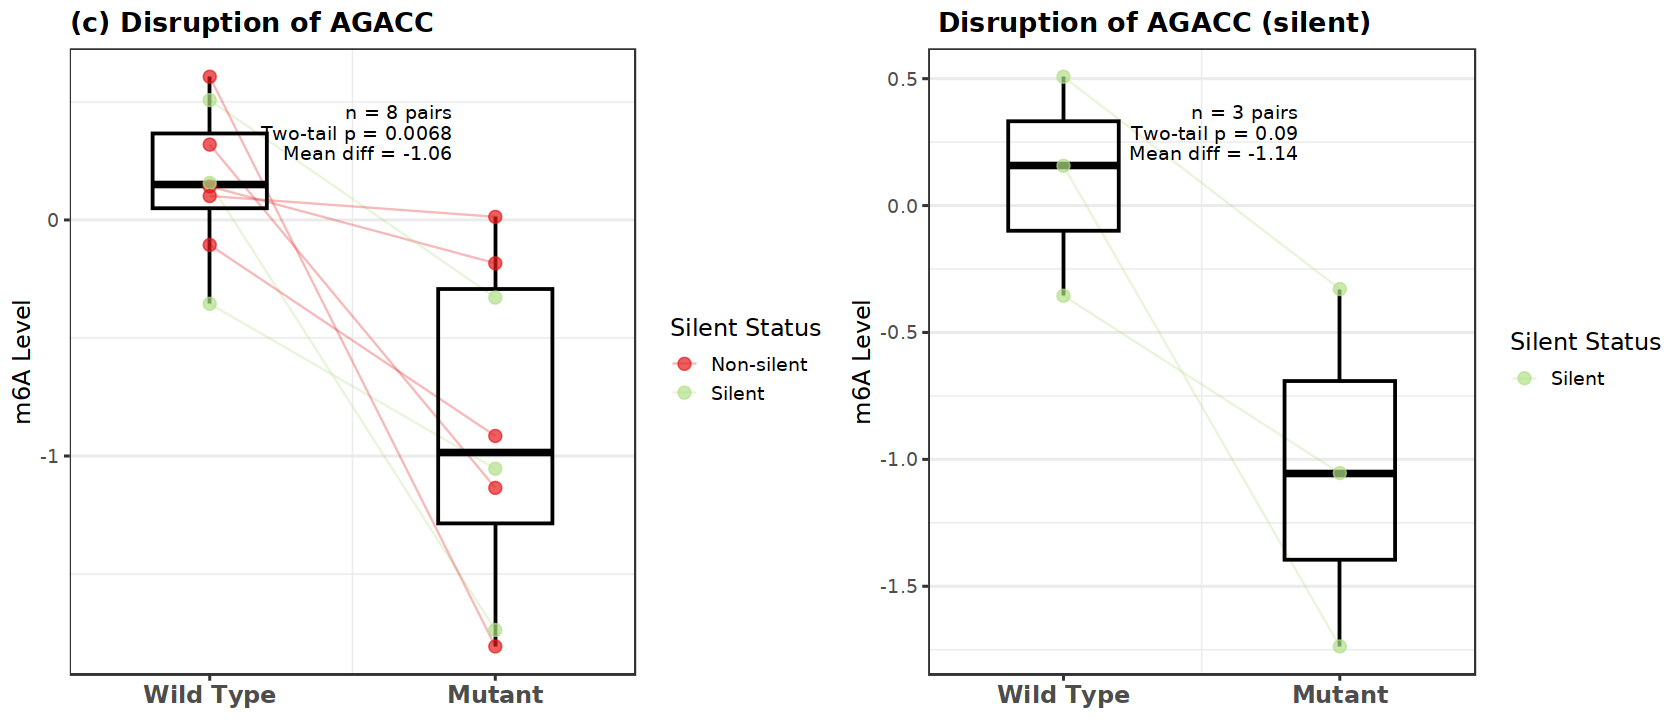

In [5]:
# Panel c: Disruption of AGACC (all + silent subset)
cat("Generating panel (c): Disruption of AGACC...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3c_all <- paired_data %>% filter(Event_Type == "Disruption", Motif == "AGACC")
figS3c_silent <- paired_data %>% filter(Event_Type == "Disruption", Motif == "AGACC", Silent_Status == "Silent")

figS3c_p1 <- create_paired_plot(figS3c_all, "Silent_Status", silent_colors,
                                "Disruption of AGACC", "(c)")
figS3c_p2 <- create_paired_plot(figS3c_silent, "Silent_Status", silent_colors,
                                "Disruption of AGACC (silent)", "")
grid.arrange(figS3c_p1, figS3c_p2, ncol = 2)

Generating panel (d): Disruption at Position 1 and 2...


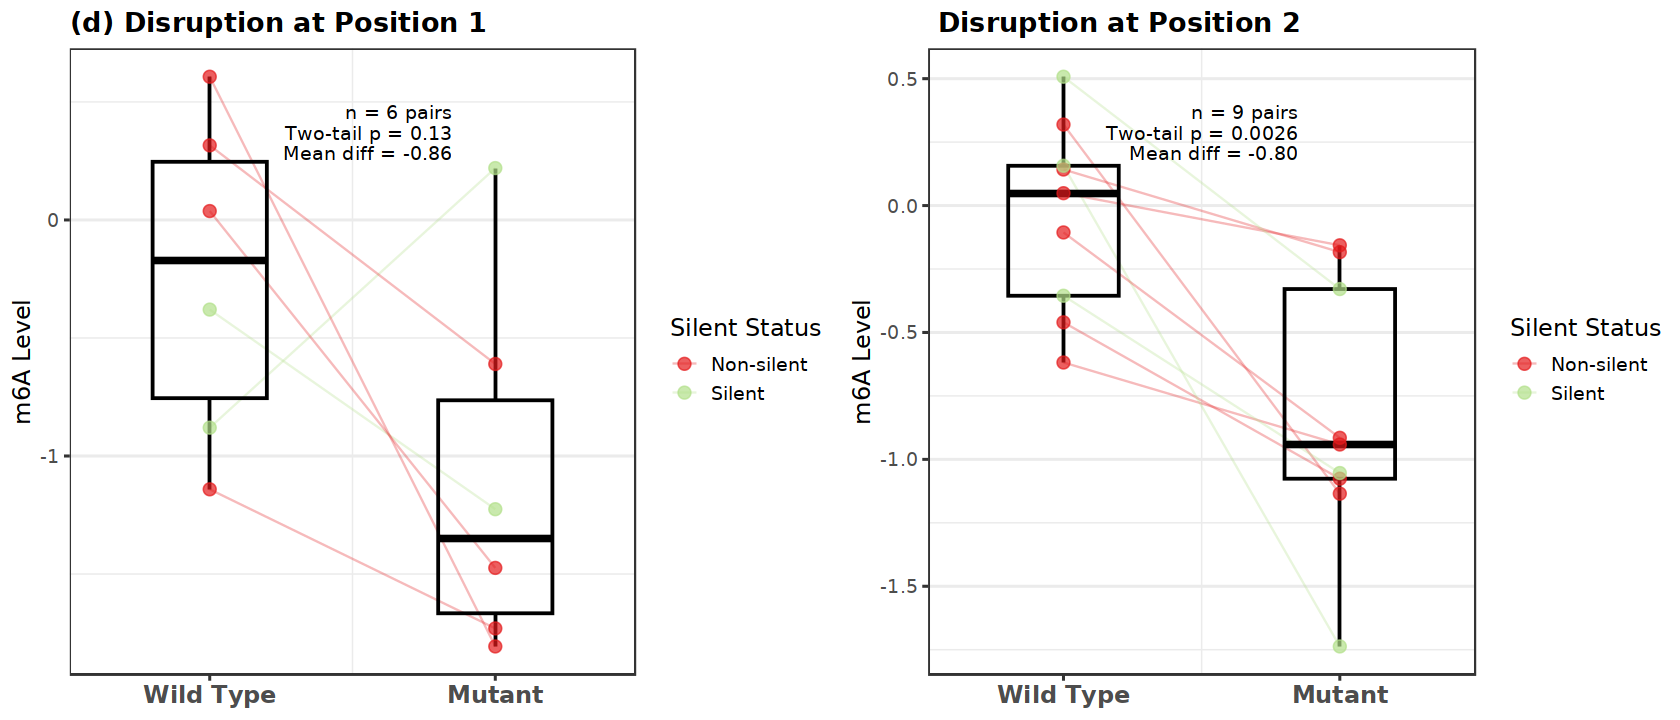

In [6]:
# Panel d: Disruption at Position 1 and 2
cat("Generating panel (d): Disruption at Position 1 and 2...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3d_pos1 <- paired_data %>% filter(Event_Type == "Disruption", Position_in_Motif == 1)
figS3d_pos2 <- paired_data %>% filter(Event_Type == "Disruption", Position_in_Motif == 2)

figS3d_p1 <- create_paired_plot(figS3d_pos1, "Silent_Status", silent_colors,
                                "Disruption at Position 1", "(d)")
figS3d_p2 <- create_paired_plot(figS3d_pos2, "Silent_Status", silent_colors,
                                "Disruption at Position 2", "")
grid.arrange(figS3d_p1, figS3d_p2, ncol = 2)

Generating panel (e): Silent Weakening distribution...


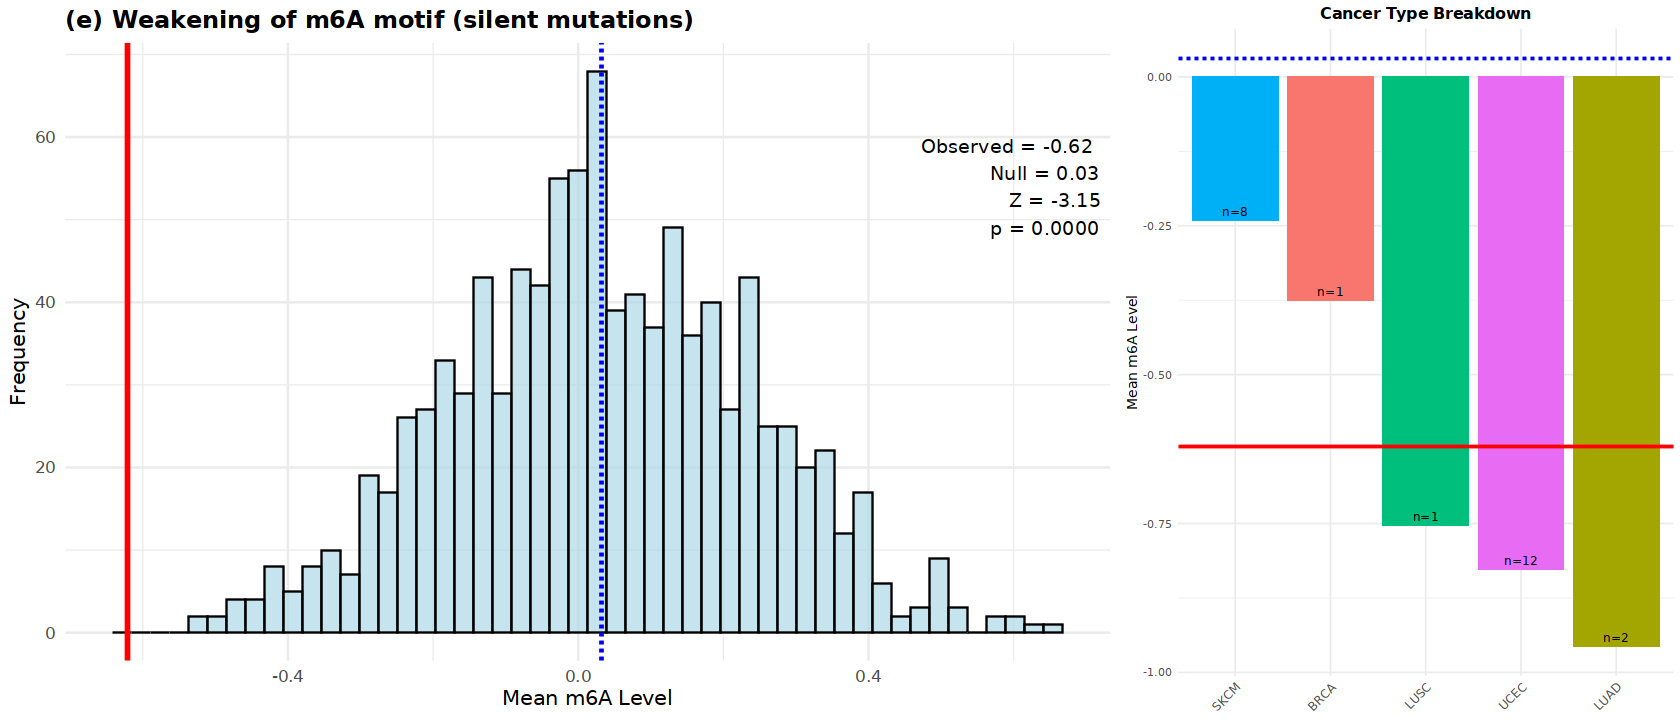

In [7]:
# Panel e: Silent Weakening distribution
cat("Generating panel (e): Silent Weakening distribution...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3e <- create_distribution_plot("Silent Weakening", level1b_combined, level1b_permutations,
                                   level1b_cancer, filter_val = "Weakening",
                                   filter_col2 = "Silent_Status", filter_val2 = "Silent",
                                   title_text = "Weakening of m6A motif (silent mutations)",
                                   panel_label = "(e)")
grid.arrange(figS3e$main, figS3e$inset, ncol = 2, widths = c(2, 1))

Generating panel (f): Weakening of GGACC...


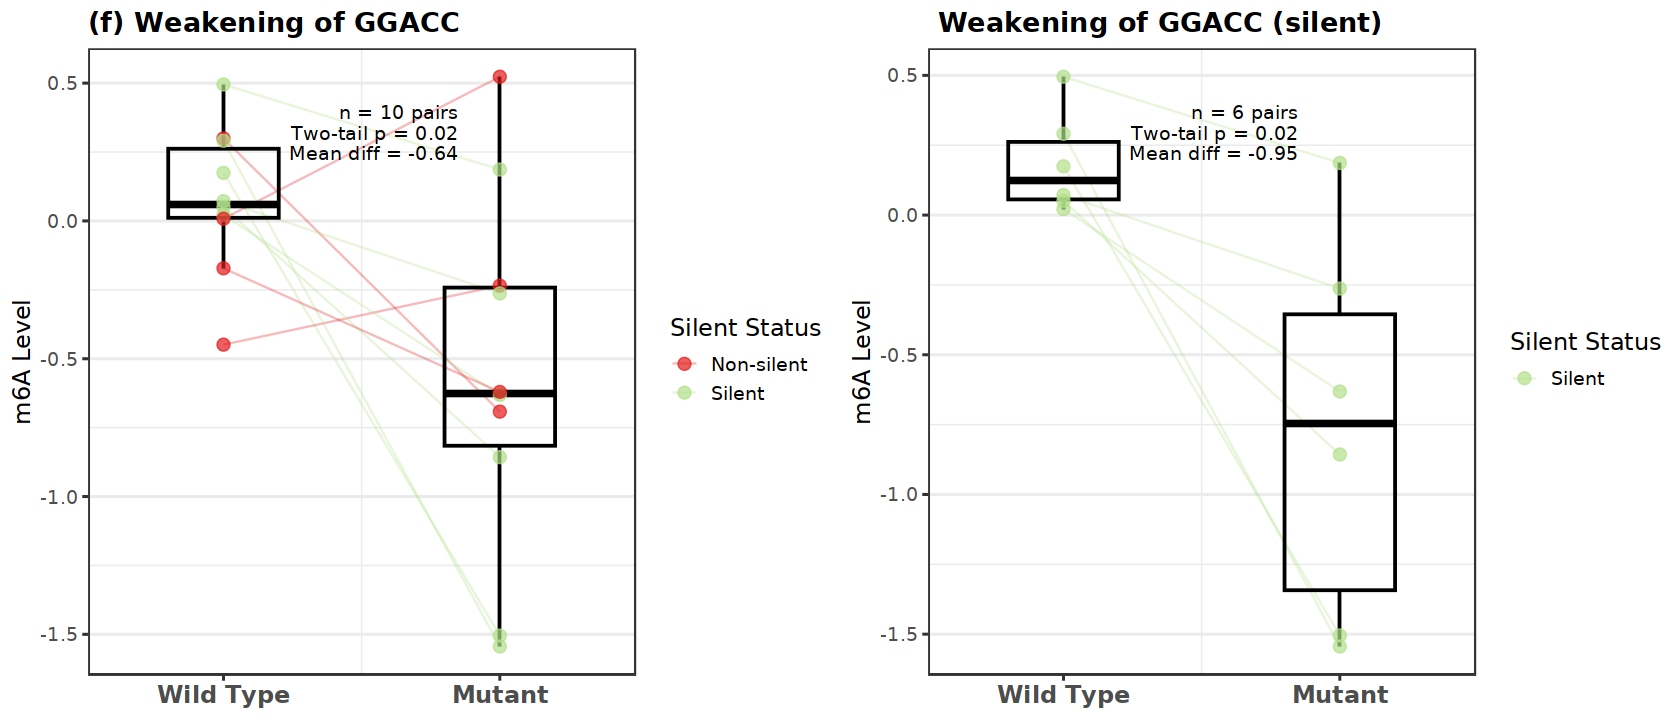

In [8]:
# Panel f: Weakening of GGACC (all + silent subset)
cat("Generating panel (f): Weakening of GGACC...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3f_all <- paired_data %>% filter(Event_Type == "Weakening", Motif == "GGACC")
figS3f_silent <- paired_data %>% filter(Event_Type == "Weakening", Motif == "GGACC", Silent_Status == "Silent")

figS3f_p1 <- create_paired_plot(figS3f_all, "Silent_Status", silent_colors,
                                "Weakening of GGACC", "(f)")
figS3f_p2 <- create_paired_plot(figS3f_silent, "Silent_Status", silent_colors,
                                "Weakening of GGACC (silent)", "")
grid.arrange(figS3f_p1, figS3f_p2, ncol = 2)

Generating panel (g): Weakening of GAACT...


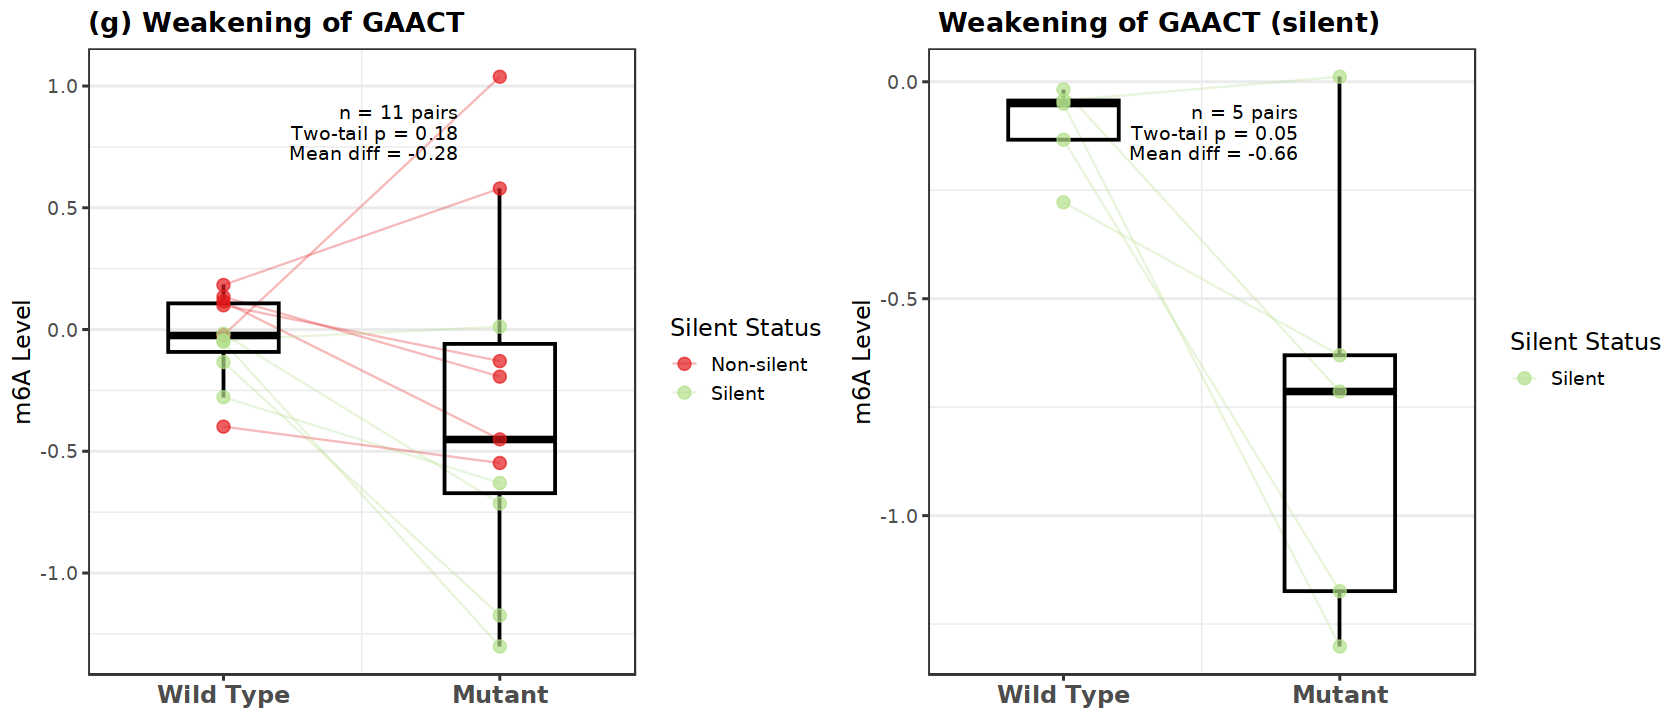

In [9]:
# Panel g: Weakening of GAACT (all + silent subset)
cat("Generating panel (g): Weakening of GAACT...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3g_all <- paired_data %>% filter(Event_Type == "Weakening", Motif == "GAACT")
figS3g_silent <- paired_data %>% filter(Event_Type == "Weakening", Motif == "GAACT", Silent_Status == "Silent")

figS3g_p1 <- create_paired_plot(figS3g_all, "Silent_Status", silent_colors,
                                "Weakening of GAACT", "(g)")
figS3g_p2 <- create_paired_plot(figS3g_silent, "Silent_Status", silent_colors,
                                "Weakening of GAACT (silent)", "")
grid.arrange(figS3g_p1, figS3g_p2, ncol = 2)

Generating panel (h): Weakening of GAACA...

✅ Figure S3 complete! (panels a-h)



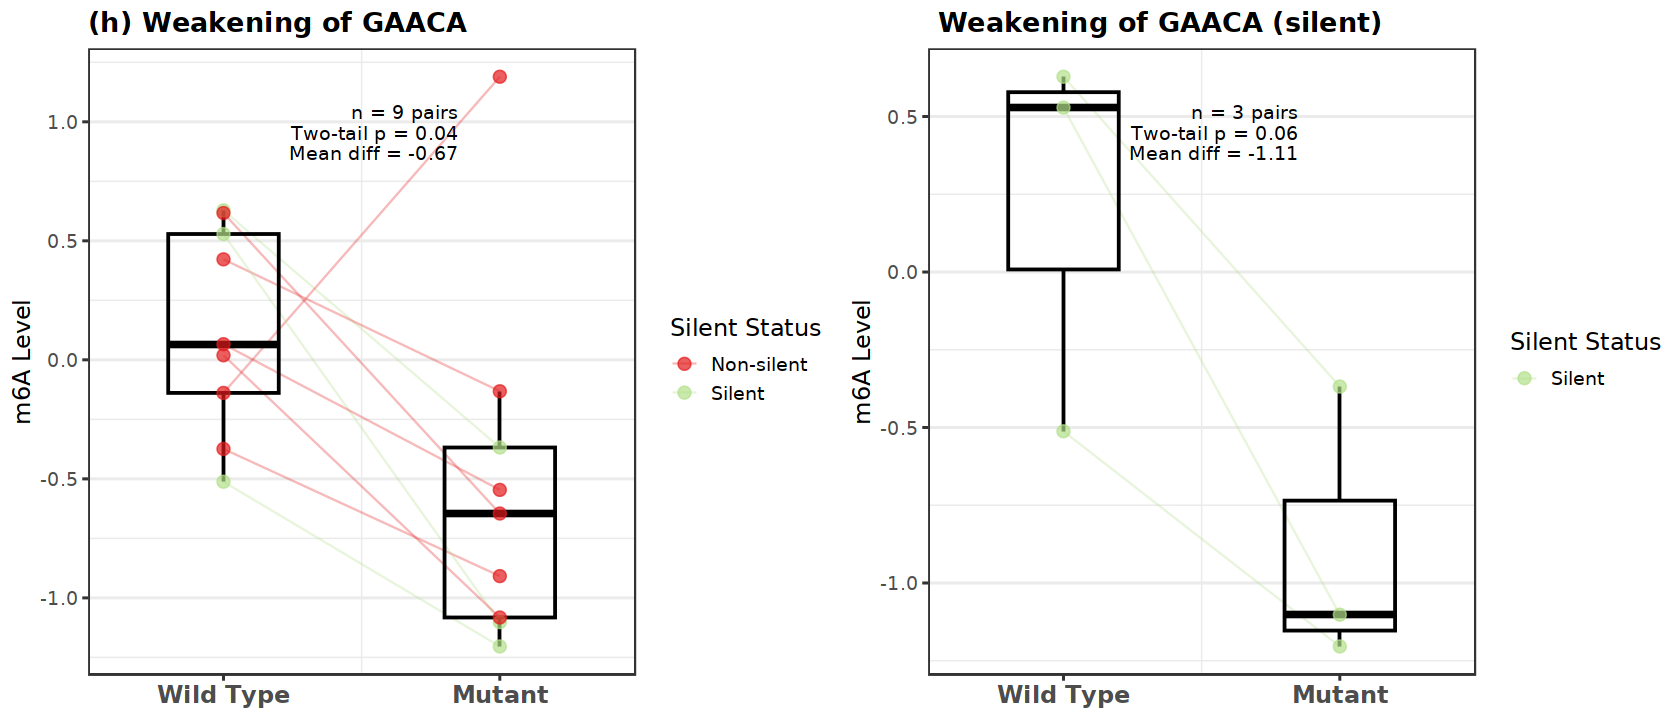

In [10]:
# Panel h: Weakening of GAACA (all + silent subset)
cat("Generating panel (h): Weakening of GAACA...\n")
options(repr.plot.width=14, repr.plot.height=6)
figS3h_all <- paired_data %>% filter(Event_Type == "Weakening", Motif == "GAACA")
figS3h_silent <- paired_data %>% filter(Event_Type == "Weakening", Motif == "GAACA", Silent_Status == "Silent")

figS3h_p1 <- create_paired_plot(figS3h_all, "Silent_Status", silent_colors,
                                "Weakening of GAACA", "(h)")
figS3h_p2 <- create_paired_plot(figS3h_silent, "Silent_Status", silent_colors,
                                "Weakening of GAACA (silent)", "")
grid.arrange(figS3h_p1, figS3h_p2, ncol = 2)

cat("\n✅ Figure S3 complete! (panels a-h)\n\n")